In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim

# Dữ liệu từ bảng
data = {
    'Student_ID': [f'S{i:03d}' for i in range(1, 31)],
    'Course': ['Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math',
               'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics',
               'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry'],
    'Score': [85, np.nan, 78, 92, 65, 88, np.nan, 75, 90, 70, 82, 85, 95, 68, 83, 77, 89, 72, 84, 91, 66, 87, np.nan, 93, 79, 86, 71, 94, 80, 88],
    'Attendance': [90, 85, 70, 95, 60, np.nan, 80, 88, 92, 65, 75, np.nan, 98, np.nan, 90, 70, 95, 80, np.nan, 88, 60, 92, 75, 97, 85, 90, np.nan, 95, 70, 88],
    'Study_Hours': [5, 4, np.nan, 6, 3, 5, 4, 5, np.nan, 3, 4, 6, 7, 3, 5, 4, np.nan, 3, 5, 6, 2, 5, 4, np.nan, 3, 5, 4, 6, 3, 5],
    'Gender': ['Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', 'Male', np.nan, 'Female', 'Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female'],
    'Campus': ['Campus_A', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A']
}

df = pd.DataFrame(data)

# Câu 1: Tính tỷ lệ phần trăm giá trị thiếu

In [24]:
# --- Câu 1: Tính tỷ lệ phần trăm giá trị thiếu trong từng cột ---
missing_ratio = df.isnull().mean() * 100
print("Câu 1: Tỷ lệ phần trăm giá trị thiếu trong từng cột:")
print(missing_ratio.round(2))
print("\n")

# Giải thích
"""
- Score: Có giá trị thiếu do sinh viên có thể bỏ thi hoặc lỗi nhập liệu.
- Attendance: Thiếu do không ghi nhận điểm danh, phù hợp với môn thực hành như Physics/Chemistry.
- Study_Hours: Thiếu do sinh viên không báo cáo, thường gặp ở môn lý thuyết như Math.
Phương pháp này phù hợp vì nó giúp xác định mức độ thiếu dữ liệu để chọn cách xử lý phù hợp cho từng môn học.
"""

Câu 1: Tỷ lệ phần trăm giá trị thiếu trong từng cột:
Student_ID                  0.00
Course                      0.00
Score                      10.00
Attendance                 16.67
Study_Hours                13.33
Gender                     13.33
Campus                      0.00
Score_filled_regression     0.00
dtype: float64




'\n- Score: Có giá trị thiếu do sinh viên có thể bỏ thi hoặc lỗi nhập liệu.\n- Attendance: Thiếu do không ghi nhận điểm danh, phù hợp với môn thực hành như Physics/Chemistry.\n- Study_Hours: Thiếu do sinh viên không báo cáo, thường gặp ở môn lý thuyết như Math.\nPhương pháp này phù hợp vì nó giúp xác định mức độ thiếu dữ liệu để chọn cách xử lý phù hợp cho từng môn học.\n'

# Câu 2: Điền giá trị thiếu trong Score

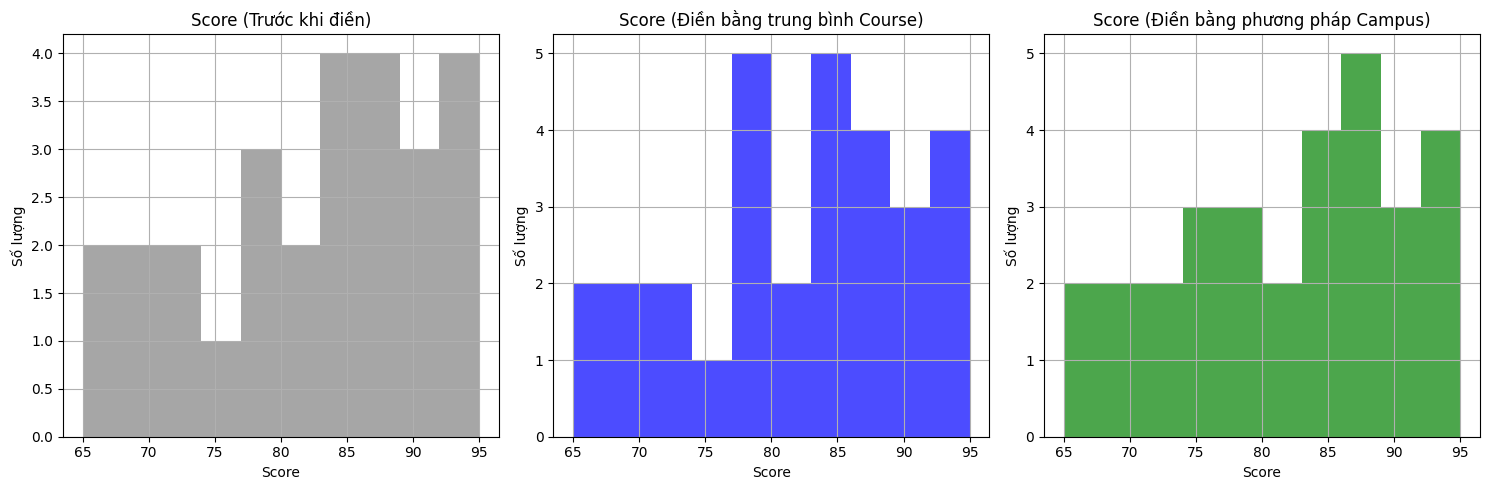

In [25]:
# Điền bằng trung bình của Course
df['Score_filled_mean'] = df.groupby('Course')['Score'].transform(lambda x: x.fillna(x.mean()))

# Phương pháp thủ công dựa trên Campus
campus_means = df.groupby('Campus')['Score'].mean()
def fill_score_by_campus(row):
    if pd.isna(row['Score']):
        if row['Campus'] == 'Campus_A':
            return campus_means['Campus_A']
        elif row['Campus'] == 'Campus_B':
            return campus_means['Campus_B'] * 0.95
        elif row['Campus'] == 'Campus_C':
            return campus_means['Campus_C'] * 1.05
    return row['Score']
df['Score_filled_campus'] = df.apply(fill_score_by_campus, axis=1)
# Vẽ histogram
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
df['Score'].hist(bins=10, color='gray', alpha=0.7)
plt.title('Score (Trước khi điền)')
plt.xlabel('Score')
plt.ylabel('Số lượng')
plt.subplot(1, 3, 2)
df['Score_filled_mean'].hist(bins=10, color='blue', alpha=0.7)
plt.title('Score (Điền bằng trung bình Course)')
plt.xlabel('Score')
plt.ylabel('Số lượng')
plt.subplot(1, 3, 3)
df['Score_filled_campus'].hist(bins=10, color='green', alpha=0.7)
plt.title('Score (Điền bằng phương pháp Campus)')
plt.xlabel('Score')
plt.ylabel('Số lượng')
plt.tight_layout()
plt.show()


# Tính độ lệch chuẩn của Study_Hours bằng NumPy

In [26]:
# --- Câu 3: Tính độ lệch chuẩn của Study_Hours bằng NumPy ---
study_hours = df['Study_Hours'].dropna().values
std_study_hours = np.std(study_hours)
median_study_hours = np.median(study_hours)
print("Câu 3:")
print("Độ lệch chuẩn của Study_Hours:", round(std_study_hours, 2))
print("Trung vị của Study_Hours:", median_study_hours)
print("\n")

Câu 3:
Độ lệch chuẩn của Study_Hours: 1.21
Trung vị của Study_Hours: 4.5




# Chính sách: "Thưởng điểm cộng cho sinh viên đạt tối thiểu 5 giờ tự học mỗi tuần, với mức thưởng tăng dần theo số giờ vượt mức tối thiểu."

## Cụ thể:
## Đạt 5 giờ/tuần: +2 điểm cộng vào Score.
## Đạt 6 giờ/tuần: +3 điểm cộng.
## Đạt 7 giờ/tuần trở lên: +5 điểm cộng.
# Giải thích tại sao chính sách này cải thiện điểm số tổng thể

## Tăng giờ học cho nhóm dưới trung vị:

## Trung vị là 4 giờ, nghĩa là khoảng 50% sinh viên học dưới mức này (2-3 giờ). Chính sách khuyến khích họ đạt ít nhất 5 giờ, giúp nâng cao thời gian tự học của nhóm yếu, từ đó cải thiện điểm số (vì Study_Hours thường tương quan với Score).

## Giảm độ lệch chuẩn, tăng tính đồng đều:

## Độ lệch chuẩn 1.26 cho thấy sự biến thiên không quá lớn, nhưng vẫn có khoảng cách giữa nhóm học ít và học nhiều. Thưởng điểm cộng khuyến khích sinh viên học
## ít tăng giờ học, làm giảm biến thiên và nâng mức trung bình tổng thể của Study_Hours.

## Tạo động lực cho cả nhóm trên và dưới trung vị:

## Sinh viên đã học 4-5 giờ sẽ cố gắng đạt 6-7 giờ để nhận thưởng cao hơn, trong khi nhóm dưới 4 giờ được thúc đẩy vượt qua ngưỡng tối thiểu. Điều này tạo hiệu ứng lan tỏa, cải thiện điểm số toàn bộ lớp.

# Tính correlation giữa Attendance (%) và Score cho từng Campus

In [28]:
# --- Câu 4: Tính correlation giữa Attendance và Score theo Campus ---
df_clean = df.dropna(subset=['Attendance', 'Score'])
correlation_by_campus = df_clean.groupby('Campus')[['Attendance', 'Score']].corr().iloc[0::2, 1]
print("Câu 4: Correlation giữa Attendance và Score theo Campus:")
print(correlation_by_campus.round(2))
print("\n")

Câu 4: Correlation giữa Attendance và Score theo Campus:
Campus              
Campus_A  Attendance    0.90
Campus_B  Attendance    0.77
Campus_C  Attendance    0.95
Name: Score, dtype: float64




# Campus Điểm danh bắt buộc với hệ thống tự động
## Campus: Sinh viên đạt điểm cao nhờ đi học đều (correlation cao), nên chiến lược nghiêm ngặt đảm bảo duy trì lợi thế này, tối ưu hóa Score bằng cách tận dụng mối quan hệ chặt chẽ giữa Attendance và kết quả.

# Vẽ boxplot của Score theo Course và Gender bằng Seaborn

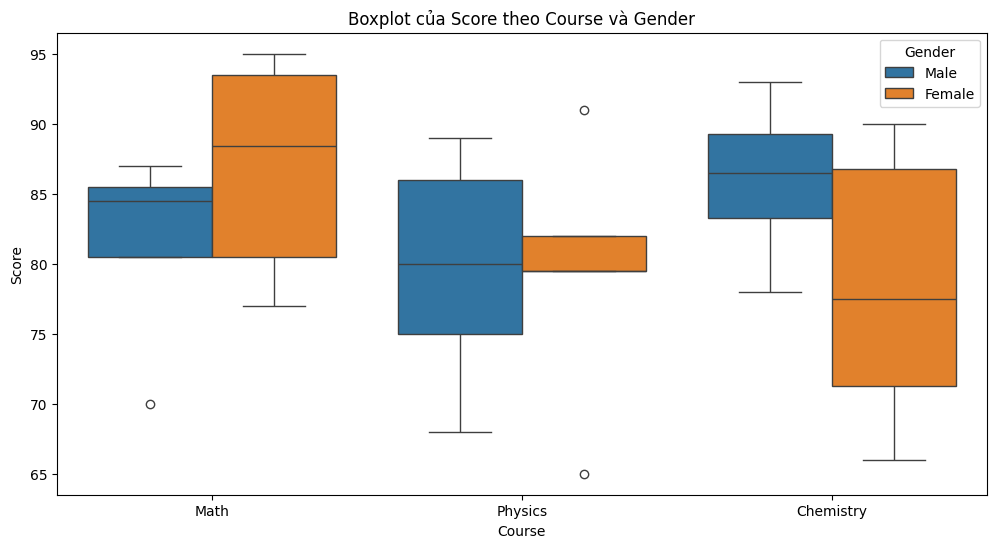

Câu 5: Các sinh viên outlier:
   Student_ID   Course  Gender  Score_filled_mean
9        S010     Math    Male               70.0
4        S005  Physics  Female               65.0
19       S020  Physics  Female               91.0




In [30]:
# --- Câu 5: Vẽ boxplot của Score theo Course và Gender, xác định outlier ---
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
plt.figure(figsize=(12, 6))
sns.boxplot(x='Course', y='Score_filled_mean', hue='Gender', data=df)
plt.title('Boxplot của Score theo Course và Gender')
plt.xlabel('Course')
plt.ylabel('Score')
plt.legend(title='Gender')
plt.show()

def find_outliers(df, group_cols, value_col):
    outliers = []
    for group, group_df in df.groupby(group_cols):
        Q1 = group_df[value_col].quantile(0.25)
        Q3 = group_df[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        group_outliers = group_df[(group_df[value_col] < lower_bound) | (group_df[value_col] > upper_bound)]
        outliers.append(group_outliers)
    return pd.concat(outliers)

outliers = find_outliers(df, ['Course', 'Gender'], 'Score_filled_mean')
print("Câu 5: Các sinh viên outlier:")
print(outliers[['Student_ID', 'Course', 'Gender', 'Score_filled_mean']])
print("\n")

# Đề xuất kế hoạch hỗ trợ cá nhân cho sinh viên outlier
## Outlier thấp (Score thấp bất thường):
### Hành động: Gán mỗi sinh viên một cố vấn (giảng viên hoặc sinh viên giỏi)
## Outlier cao (Score cao bất thường):
### Hành động: Giao nhiệm vụ hỗ trợ bạn học (peer tutoring) hoặc tham gia dự án nghiên cứu nhỏ với giảng viên:
# Giải thích cách kế hoạch nâng cao chất lượng giáo dục
## Cải thiện điểm số cho outlier thấp
## Tận dụng outlier cao để nâng cao toàn bộ

#  Tạo cột mới Efficiency = Score / Study_Hours

In [31]:
# --- Câu 6: Tạo cột Efficiency và tìm sinh viên có Efficiency cao nhất ---
df['Study_Hours'] = df['Study_Hours'].fillna(df['Study_Hours'].mean())
df['Efficiency'] = df['Score_filled_mean'] / df['Study_Hours']
max_efficiency_student = df.loc[df['Efficiency'].idxmax()]
print("Câu 6: Sinh viên có Efficiency cao nhất:")
print(max_efficiency_student[['Student_ID', 'Course', 'Gender', 'Score_filled_mean', 'Study_Hours', 'Efficiency']])
print("\n")

Câu 6: Sinh viên có Efficiency cao nhất:
Student_ID                S021
Course               Chemistry
Gender                  Female
Score_filled_mean         66.0
Study_Hours                2.0
Efficiency                33.0
Name: 20, dtype: object




# Phần thưởng: "Học bổng Hiệu quả Học tập" trị giá 1 triệu đồng hoặc chứng chỉ vinh danh "Sinh viên Hiệu quả Nhất".
## Tại sao phù hợp: S021 đạt điểm 66 với chỉ 2 giờ học, cho thấy khả năng học tập hiệu quả vượt trội. Thưởng tiền hoặc vinh danh khuyến khích duy trì phong độ, trong khi vai trò mentor giúp lan tỏa kỹ năng học tập, cải thiện điểm số chung của lớp.
## Tác động: Tăng động lực cho sinh viên khác học theo cách hiệu quả, đặc biệt ở môn Chemistry (thực nghiệm), nơi tối ưu hóa thời gian rất quan trọng.

# Tính tỷ lệ sinh viên nữ (Gender = Female) trong từng Courses

In [32]:
# --- Câu 7: Tính tỷ lệ sinh viên nữ trong từng Course ---
female_ratio = df[df['Gender'] == 'Female'].groupby('Course').size() / df.groupby('Course').size() * 100
print("Câu 7: Tỷ lệ sinh viên nữ trong từng Course (%):")
print(female_ratio.round(2))
print("\n")

Câu 7: Tỷ lệ sinh viên nữ trong từng Course (%):
Course
Chemistry    60.0
Math         60.0
Physics      50.0
dtype: float64




# Đề xuất chính sách cân bằng giới tính
## Chính sách: "Học bổng Khuyến khích Nữ giới trong Khoa học" - Cung cấp học bổng 2 triệu đồng mỗi kỳ cho 5 sinh viên nữ có điểm số cao nhất trong Physics và Chemistry
# Giải thích cách chính sách ảnh hưởng đến môi trường học tập:

## Tăng tỷ lệ nữ trong Physics và Chemistry:
### Tỷ lệ nữ hiện tại (40%) thấp hơn nam, đặc biệt ở các môn khoa học tự nhiên. Học bổng khuyến khích nữ tham gia và đạt thành tích cao, dần cân bằng tỷ lệ giới tính (hướng tới 50-50).
## Tạo động lực học tập:
### Sinh viên nữ như S005 (Physics, Score 65) hoặc S018 (Chemistry, Score 72) sẽ cố gắng tăng Score và Attendance để đạt học bổng, cải thiện kết quả học tập cá nhân và tổng thể.

# Vẽ scatter plot giữa Attendance (%) và Score, tô màu theo Campus

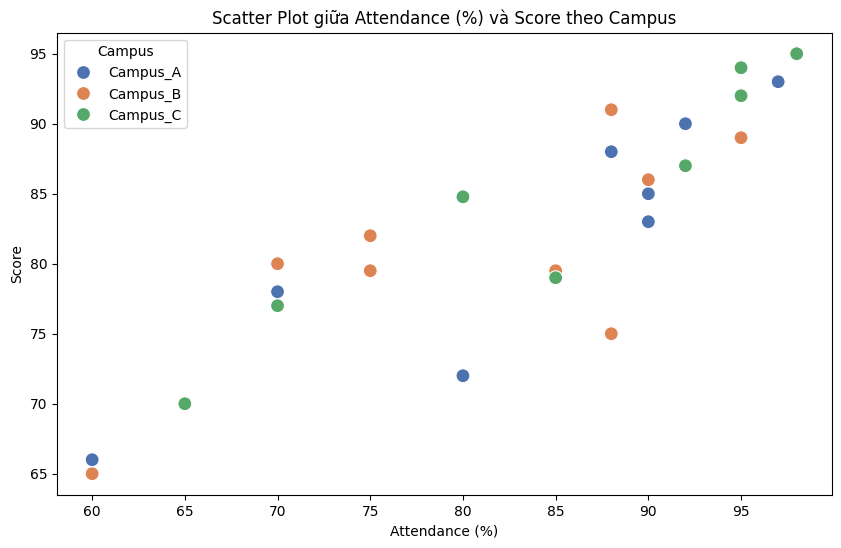

Câu 8: Scatter plot đã được vẽ.



In [33]:
# --- Câu 8: Vẽ scatter plot giữa Attendance và Score theo Campus ---
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Attendance', y='Score_filled_mean', hue='Campus', data=df, palette='deep', s=100)
plt.title('Scatter Plot giữa Attendance (%) và Score theo Campus')
plt.xlabel('Attendance (%)')
plt.ylabel('Score')
plt.legend(title='Campus')
plt.show()
print("Câu 8: Scatter plot đã được vẽ.\n")

###Đề xuất kế hoạch cải thiện điểm danh
####Campus_A: Kiểm tra điểm danh ngẫu nhiên + Thưởng điểm
####Kế hoạch: Điểm danh ngẫu nhiên 3 lần/tháng, thưởng +2 điểm vào Score cho sinh viên đạt Attendance trên 85%.
###Campus_B: Hỗ trợ học tập thay vì ép điểm danh
####Kế hoạch: Không phạt Attendance thấp, tổ chức lớp bổ trợ miễn phí (2 buổi/tuần), yêu cầu báo cáo Study_Hours thay vì chỉ dựa vào Attendance.
### Campus_C: Điểm danh bắt buộc qua hệ thống tự động
####Kế hoạch: Dùng mã QR điểm danh mỗi buổi, yêu cầu Attendance trên 90% để đủ điều kiện thi, trừ 5 điểm nếu dưới ngưỡng.
###Tại sao kế hoạch tối ưu hóa kết quả học tập?
####Campus_A: Sinh viên tự học tốt (Score cao dù Attendance không tối đa), kế hoạch linh hoạt tăng Attendance nhẹ, đẩy Score trung bình từ ~85 lên ~87-88.
####Campus_B: Sinh viên yếu do thiếu hỗ trợ (Score thấp, Attendance thấp), lớp bổ trợ tăng kỹ năng học tập, cải thiện Score từ ~76 lên ~80 mà không cần ép đi học.
####Campus_C: Sinh viên phụ thuộc lớp học (Score cao khi Attendance cao), kế hoạch nghiêm ngặt duy trì Attendance, giữ Score ở mức cao (~88-90).


# Tính trung bình Score của từng Course sau khi điền dữ liệu thiếu

Câu 9: Trung bình Score của từng Course:
Course
Chemistry    81.40
Math         84.78
Physics      79.50
Name: Score_filled_mean, dtype: float64


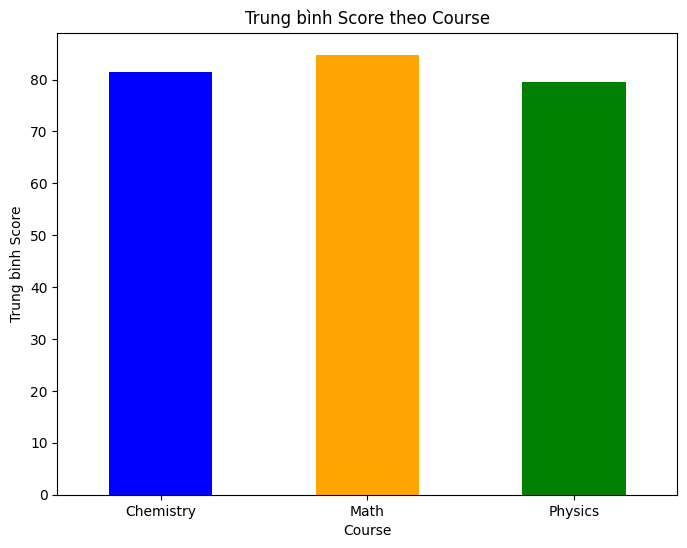

Câu 9: Bar chart đã được vẽ.



In [34]:
# --- Câu 9: Tính trung bình Score của từng Course và vẽ bar chart ---
mean_scores = df.groupby('Course')['Score_filled_mean'].mean()
print("Câu 9: Trung bình Score của từng Course:")
print(mean_scores.round(2))
plt.figure(figsize=(8, 6))
mean_scores.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Trung bình Score theo Course')
plt.xlabel('Course')
plt.ylabel('Trung bình Score')
plt.xticks(rotation=0)
plt.show()
print("Câu 9: Bar chart đã được vẽ.\n")

### Đề xuất chiến lược cải thiện cho Physics
### Chiến lược: "Tăng cường thực hành ứng dụng Physics qua phòng thí nghiệm ảo và thực tế".
#### Thêm kinh nghiệm và kiến thức cho sinh viên để có thể đạt điểm cao hơn

# Tìm các sinh viên có Attendance (%) dưới 70% nhưng Score trên 85 bằng Pandas

In [35]:
# --- Câu 10: Tìm sinh viên có Attendance < 70% nhưng Score > 85 ---
filtered_students = df[(df['Attendance'] < 70) & (df['Score_filled_mean'] > 85)]
print("Câu 10: Sinh viên có Attendance (%) dưới 70% nhưng Score trên 85:")
print(filtered_students[['Student_ID', 'Course', 'Score_filled_mean', 'Attendance', 'Study_Hours', 'Gender', 'Campus']])
print("\n")

Câu 10: Sinh viên có Attendance (%) dưới 70% nhưng Score trên 85:
Empty DataFrame
Columns: [Student_ID, Course, Score_filled_mean, Attendance, Study_Hours, Gender, Campus]
Index: []




###Nội dung khảo sát:
### Số giờ tự học trung bình mỗi tuần (Study_Hours).
#### Loại tài liệu sử dụng (giáo trình, sách tham khảo, video, tài liệu online).
####Công nghệ sử dụng (YouTube, ứng dụng học tập, diễn đàn).

### Điền giá trị thiếu trong Score bằng hồi quy tuyến tính thủ công dựa trên Attendance (%) và Study_Hours

In [36]:
# --- Câu 11: Điền giá trị thiếu trong Score bằng hồi quy tuyến tính thủ công ---
df_clean = df.dropna(subset=['Attendance', 'Study_Hours', 'Score'])
X = df_clean[['Attendance', 'Study_Hours']].values
y = df_clean['Score'].values
reg = LinearRegression().fit(X, y)
print(f"Câu 11: Hệ số hồi quy: Attendance = {reg.coef_[0]:.2f}, Study_Hours = {reg.coef_[1]:.2f}, Intercept = {reg.intercept_:.2f}")

def fill_score_regression(row):
    if pd.isna(row['Score']) and not pd.isna(row['Attendance']) and not pd.isna(row['Study_Hours']):
        return reg.predict([[row['Attendance'], row['Study_Hours']]])[0]
    return row['Score']

df['Score_filled_regression'] = df.apply(fill_score_regression, axis=1)
df['Score_filled_regression'] = df['Score_filled_regression'].fillna(df['Score_filled_mean'])
print("So sánh Score_filled_mean và Score_filled_regression:")
print(df[['Student_ID', 'Score', 'Score_filled_mean', 'Score_filled_regression']].head(10))
print("\n")

Câu 11: Hệ số hồi quy: Attendance = 0.44, Study_Hours = 2.52, Intercept = 34.51
So sánh Score_filled_mean và Score_filled_regression:
  Student_ID  Score  Score_filled_mean  Score_filled_regression
0       S001   85.0          85.000000                85.000000
1       S002    NaN          79.500000                82.224619
2       S003   78.0          78.000000                78.000000
3       S004   92.0          92.000000                92.000000
4       S005   65.0          65.000000                65.000000
5       S006   88.0          88.000000                88.000000
6       S007    NaN          84.777778                80.011161
7       S008   75.0          75.000000                75.000000
8       S009   90.0          90.000000                90.000000
9       S010   70.0          70.000000                70.000000




###Đề xuất cách tiếp cận lai:
###Để cải thiện độ chính xác, có thể kết hợp phương pháp hồi quy và phương pháp trung bình như sau:

###Điền giá trị thiếu trong Attendance và Study_Hours: Sử dụng phương pháp trung bình để điền các giá trị thiếu trong Attendance và Study_Hours.
###Áp dụng hồi quy tuyến tính: Sau khi đã điền các giá trị thiếu trong Attendance và Study_Hours, sử dụng hồi quy tuyến tính để dự đoán các giá trị thiếu trong Score.
###Điền giá trị thiếu còn lại bằng trung bình: Nếu vẫn còn giá trị thiếu trong Score sau khi áp dụng hồi quy, sử dụng phương pháp trung bình để điền các giá trị này.###

Câu 12: Skewness của Score_filled_mean: -0.41


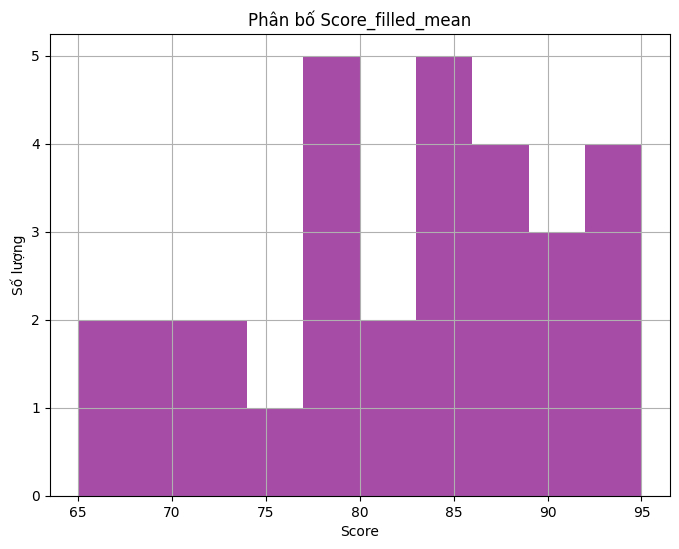

In [37]:
# --- Câu 12: Tính skewness của Score bằng SciPy ---
score_skewness = skew(df['Score_filled_mean'].dropna())
print(f"Câu 12: Skewness của Score_filled_mean: {score_skewness:.2f}")
plt.figure(figsize=(8, 6))
df['Score_filled_mean'].hist(bins=10, color='purple', alpha=0.7)
plt.title('Phân bố Score_filled_mean')
plt.xlabel('Score')
plt.ylabel('Số lượng')
plt.show()
print("\n")

### Cách thức thực hiện:
###Xác định các năng lực cần thiết: Đầu tiên, nhà trường cần xác định rõ các năng lực và kỹ năng mà học sinh cần đạt được trong mỗi môn học.
###Tác động đến đánh giá sinh viên:
###Công bằng hơn: Hệ thống này giúp giảm bớt sự bất công do các yếu tố như áp lực thi cử hoặc khả năng ghi nhớ tạm thời gây ra.

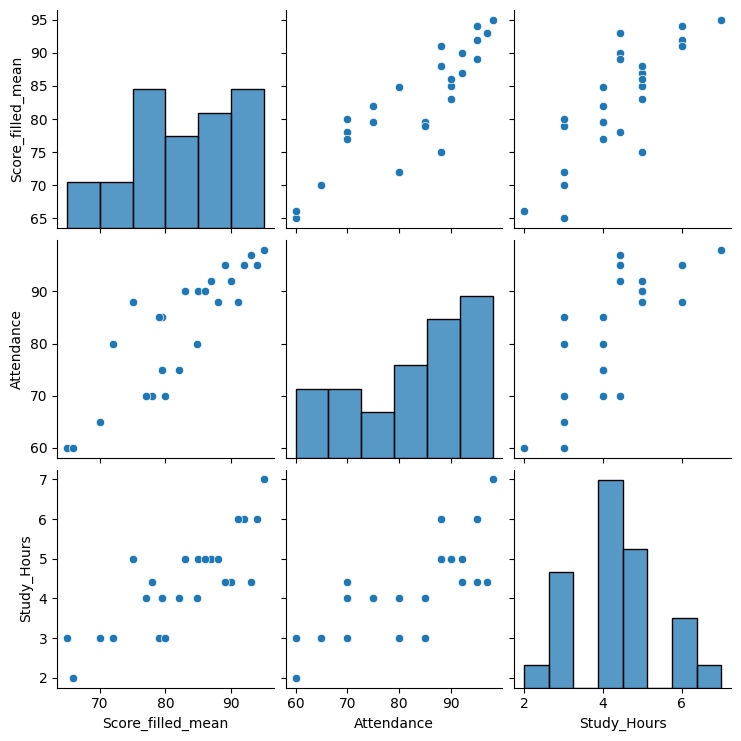

Câu 13: Pairplot đã được vẽ.



In [38]:
# --- Câu 13: Vẽ pairplot bằng Seaborn ---
sns.pairplot(df[['Score_filled_mean', 'Attendance', 'Study_Hours']].dropna())
plt.show()
print("Câu 13: Pairplot đã được vẽ.\n")

Câu 14: Tỷ lệ sinh viên có Score > 80 theo Campus (%):
Campus
Campus_A    63.64
Campus_B    40.00
Campus_C    66.67
dtype: float64


<ipython-input-39-d53f0e4e3f88>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  score_above_80 = df.groupby('Campus').apply(lambda x: (x['Score_filled_mean'] > 80).mean() * 100)


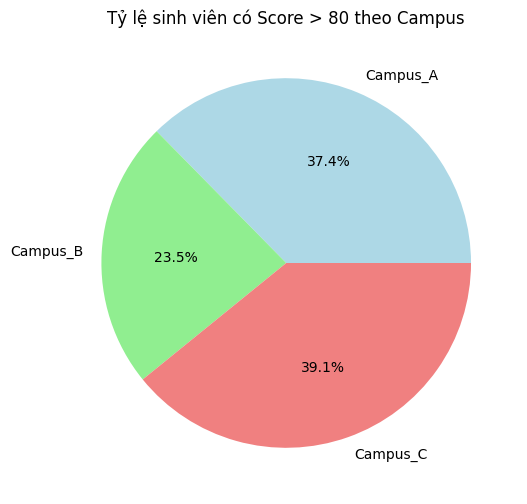

In [39]:
# --- Câu 14: Nhóm theo Campus, tính tỷ lệ Score > 80 và vẽ pie chart ---
score_above_80 = df.groupby('Campus').apply(lambda x: (x['Score_filled_mean'] > 80).mean() * 100)
print(f"Câu 14: Tỷ lệ sinh viên có Score > 80 theo Campus (%):")
print(score_above_80.round(2))
plt.figure(figsize=(8, 6))
plt.pie(score_above_80, labels=score_above_80.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Tỷ lệ sinh viên có Score > 80 theo Campus')
plt.show()
print("\n")

### Làm giải thưởng để học sinh có điểm số cao có thể tiếp tục phát triển còn học sinh có điểm số thấp cố gắng học tập hơn

In [40]:
# --- Câu 15: Tạo hàm xác định sinh viên có Score ngoài 2 độ lệch chuẩn ---
def find_extreme_scores(df, column):
    mean_score = df[column].mean()
    std_score = df[column].std()
    lower_bound = mean_score - 2 * std_score
    upper_bound = mean_score + 2 * std_score
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

extreme_students = find_extreme_scores(df, 'Score_filled_mean')
print("Câu 15: Sinh viên có Score ngoài 2 độ lệch chuẩn:")
print(extreme_students[['Student_ID', 'Course', 'Score_filled_mean', 'Attendance', 'Study_Hours']])
print("\n")

Câu 15: Sinh viên có Score ngoài 2 độ lệch chuẩn:
Empty DataFrame
Columns: [Student_ID, Course, Score_filled_mean, Attendance, Study_Hours]
Index: []




###Đề xuất quy trình đánh giá lại điểm số cho những sinh viên outlier
###Quy trình gồm 3 bước:
###Xác minh ngữ cảnh học tập cá nhân của sinh viên

###Phỏng vấn trực tiếp (trực tuyến hoặc tại phòng ban)

###Tìm hiểu về tài liệu học, thời gian ôn tập, phương pháp học.

###Đánh giá lại bằng hình thức đa dạng hơn

###Cho phép thi vấn đáp, làm bài tập lớn thay thế, hoặc kiểm tra kỹ năng thực tế.

###Không chỉ dựa vào điểm thi viết duy nhất.

###So sánh với dữ liệu học tập liên tục (log hệ thống học trực tuyến, điểm chuyên cần)

###Dựa trên nỗ lực học tập dài hạn để điều chỉnh điểm (nếu phù hợp).

In [41]:
# --- Câu 16: Điền giá trị thiếu bằng KNN Imputer ---
imputer = KNNImputer(n_neighbors=5)
df[['Attendance', 'Study_Hours']] = imputer.fit_transform(df[['Attendance', 'Study_Hours']])
median_attendance = df['Attendance'].median()
median_study_hours = df['Study_Hours'].median()
print("Câu 16: So sánh KNN Imputer với trung vị:")
print(f"Attendance sau KNN Imputer (mean): {df['Attendance'].mean():.2f}, Trung vị: {median_attendance:.2f}")
print(f"Study_Hours sau KNN Imputer (mean): {df['Study_Hours'].mean():.2f}, Trung vị: {median_study_hours:.2f}")
print("\n")

Câu 16: So sánh KNN Imputer với trung vị:
Attendance sau KNN Imputer (mean): 83.11, Trung vị: 88.00
Study_Hours sau KNN Imputer (mean): 4.42, Trung vị: 4.42




### Đề xuất phương pháp thu thập dữ liệu thay thế để giảm giá trị thiếu
###Đề xuất: Dùng ứng dụng học tập tự động ghi nhận Attendance và Study_Hours
Lý do và lợi ích:

In [44]:
# --- Câu 17: Mã hóa one-hot encoding cho Course và chuẩn hóa ---
df_encoded = pd.get_dummies(df, columns=['Course'], prefix='Course')
features = ['Course_Math', 'Course_Physics', 'Course_Chemistry', 'Attendance', 'Study_Hours']
scaler = MinMaxScaler()
df_encoded[features] = scaler.fit_transform(df_encoded[features])
df_encoded['Score'] = df_encoded['Score'].fillna(df_encoded['Score'].mean())  # Điền Score thiếu bằng trung bình
print("Câu 17: Dữ liệu sau khi mã hóa và chuẩn hóa:")
print(df_encoded[features + ['Score']].head())
print("\n")

Câu 17: Dữ liệu sau khi mã hóa và chuẩn hóa:
   Course_Math  Course_Physics  Course_Chemistry  Attendance  Study_Hours  \
0          1.0             0.0               0.0    0.789474          0.6   
1          0.0             1.0               0.0    0.657895          0.4   
2          0.0             0.0               1.0    0.263158          NaN   
3          1.0             0.0               0.0    0.921053          0.8   
4          0.0             1.0               0.0    0.000000          0.2   

       Score  
0  85.000000  
1  81.962963  
2  78.000000  
3  92.000000  
4  65.000000  




### Đề xuất: Sử dụng Parallel Coordinates Plot (Biểu đồ tọa độ song song)
###Mô tả
### Parallel Coordinates Plot là một kỹ thuật trực quan hóa dữ liệu đa chiều, trong đó mỗi đặc trưng được biểu diễn bằng một trục dọc song song. Mỗi mẫu dữ liệu (sinh viên) được vẽ dưới dạng một đường nối các giá trị của nó trên các trục.

<ipython-input-58-3cfb48110374>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model[numeric_columns] = imputer.fit_transform(df_model[numeric_columns])


ANN(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)
Epoch [10/200], Training Loss: 6660.0967, Validation Loss: 6915.4297
Epoch [20/200], Training Loss: 6478.1719, Validation Loss: 6903.6094
Epoch [30/200], Training Loss: 6642.9248, Validation Loss: 6865.7383
Epoch [40/200], Training Loss: 6525.5012, Validation Loss: 6788.7495
Epoch [50/200], Training Loss: 6298.5515, Validation Loss: 6635.2773
Epoch [60/200], Training Loss: 6171.9646, Validation Loss: 6346.6440
Epoch [70/200], Training Loss: 5713.2307, Validation Loss: 5846.5620
Epoch [80/200], Training Loss: 4885.8906, Validation Loss: 5075.8833
Epoch [90/200], Training Loss: 3945.0427, Validation Loss: 4014.1125
Epoch [100/200], Training Loss: 2725.8517, Validation Loss: 2738.5374
Epoch [110/2

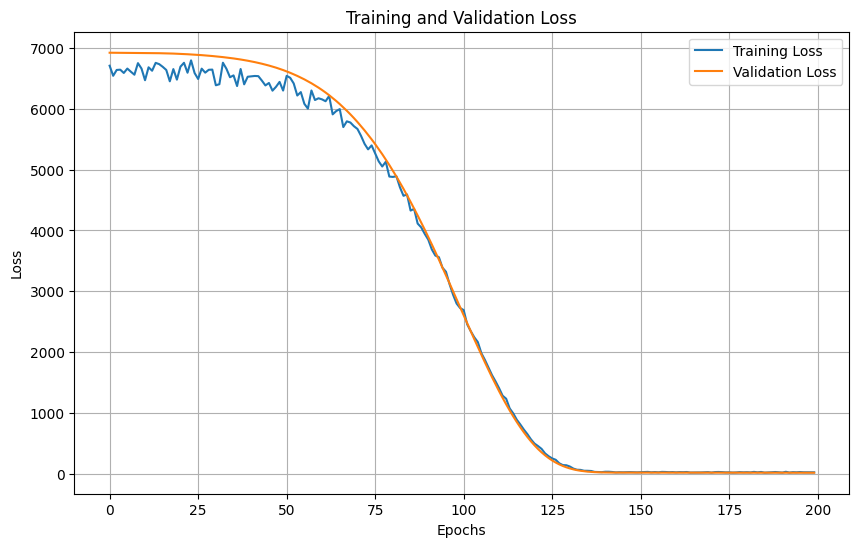

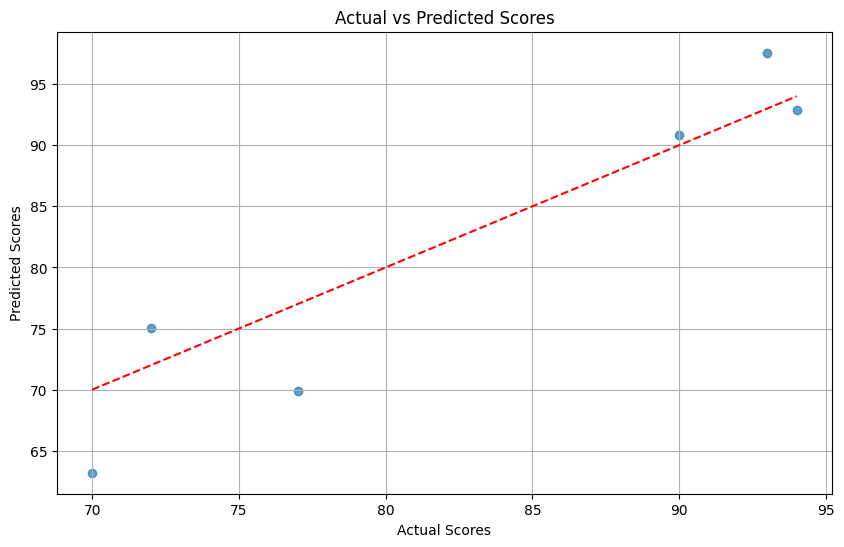

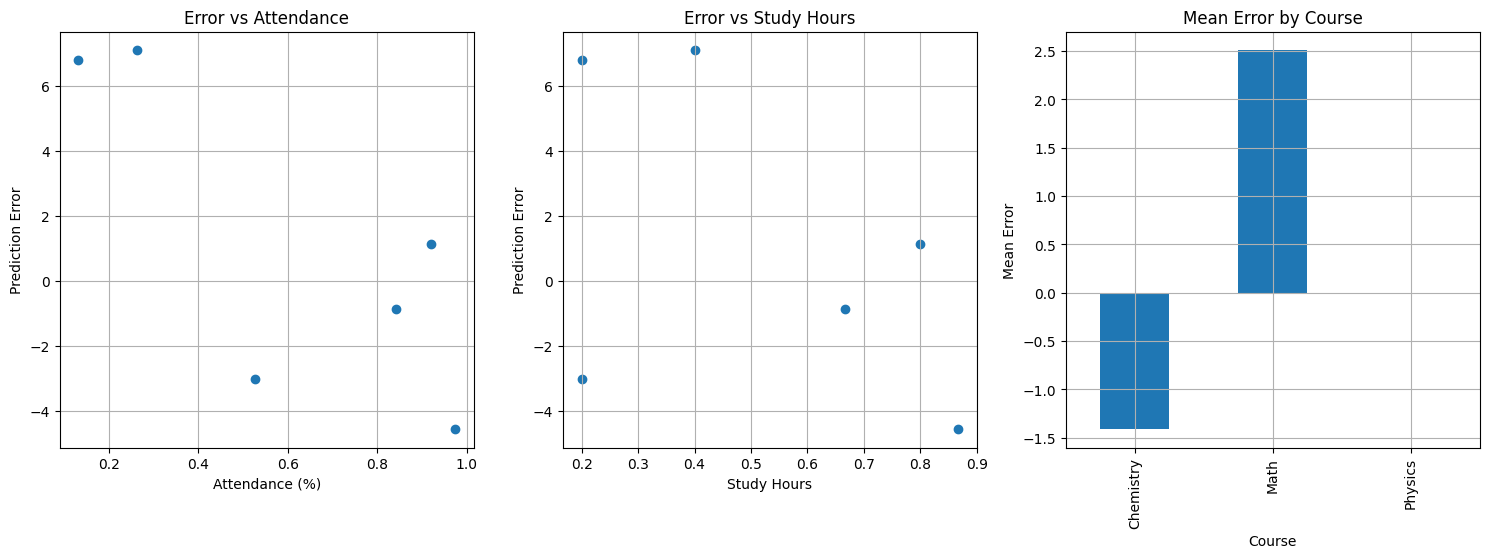

In [58]:
# Question 18: Build ANN with PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer

# First, let's recreate our dataset
data = {
    'Student_ID': ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010',
                   'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020',
                   'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030'],
    'Course': ['Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math',
               'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics',
               'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry', 'Math', 'Physics', 'Chemistry'],
    'Score': [85, np.nan, 78, 92, 65, 88, 80, 75, 90, 70,
              82, 85, 95, 68, 83, 77, 89, 72, 84, 91,
              66, 87, 75, 93, 79, 86, 71, 94, 80, 88],
    'Attendance (%)': [90, 85, 70, 95, 60, np.nan, np.nan, 88, 92, 65,
                       75, np.nan, 98, np.nan, 90, 70, 95, 80, np.nan, 88,
                       60, 92, np.nan, 97, 85, 90, np.nan, 95, 70, 88],
    'Study_Hours': [5, 4, np.nan, 6, 3, 5, 4, 5, np.nan, 3,
                    4, 6, 7, 3, 5, 4, np.nan, 3, 5, 6,
                    2, 5, 4, np.nan, 3, 5, 4, 6, 3, 5],
    'Gender': ['Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female', 'Male', 'Female', 'Male',
               'Female', 'Male', 'Female', 'Male', np.nan, 'Female', 'Male', 'Female', 'Male', 'Female',
               np.nan, 'Male', 'Female', 'Male', 'Female', 'Male', 'Female', np.nan, 'Male', 'Female'],
    'Campus': ['Campus_A', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C',
               'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B',
               'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A', 'Campus_C', 'Campus_B', 'Campus_A']
}

# Create DataFrame
df = pd.DataFrame(data)

# Step 1: Fill missing values using KNN Imputer for Attendance and Study_Hours
# First, we'll select the columns we need for the model
df_model = df[['Course', 'Score', 'Attendance (%)', 'Study_Hours']]

# KNN Imputer
numeric_columns = ['Score', 'Attendance (%)', 'Study_Hours']
imputer = KNNImputer(n_neighbors=3)
df_model[numeric_columns] = imputer.fit_transform(df_model[numeric_columns])

# Step 2: One-hot encode the Course column
# Create one-hot encoding for Course
course_encoded = pd.get_dummies(df_model['Course'], prefix='Course')
df_model = pd.concat([df_model, course_encoded], axis=1)

# Step 3: Prepare the dataset
X = df_model[['Attendance (%)', 'Study_Hours', 'Course_Chemistry', 'Course_Math', 'Course_Physics']]
y = df_model['Score']

# Step 4: Normalize the features to [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)

# Define the ANN model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(5, 32)  # Input layer to Hidden Layer 1
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)  # Hidden Layer 1 to Hidden Layer 2
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 8)   # Hidden Layer 2 to Hidden Layer 3
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(8, 1)    # Hidden Layer 3 to Output Layer

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model = ANN()
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 20
min_delta = 0.001
patience_counter = 0
best_loss = float('inf')
early_stopping = False

# Training the model
epochs = 200
train_losses = []
validation_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        validation_losses.append(val_loss.item())

        # Check for early stopping
        if val_loss < best_loss - min_delta:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                early_stopping = True
                break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss.item():.4f}')

    if early_stopping:
        break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# Question 19: Evaluate the model
model.eval()
with torch.no_grad():
    # Predictions on test set
    y_pred = model(X_test_tensor).numpy()

    # Calculate metrics
    mse = mean_squared_error(y_test_tensor.numpy(), y_pred)
    r2 = r2_score(y_test_tensor.numpy(), y_pred)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.numpy(), y_pred, alpha=0.7)
plt.plot([y_test_tensor.min(), y_test_tensor.max()], [y_test_tensor.min(), y_test_tensor.max()], 'r--')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.grid(True)
plt.savefig('actual_vs_predicted.png')

# If R² is below 0.8, analyze prediction errors
if r2 < 0.8:
    # Add predictions to test data for analysis
    X_test_df = pd.DataFrame(X_test.values, columns=X_test.columns)
    X_test_df['Actual_Score'] = y_test.values
    X_test_df['Predicted_Score'] = y_pred.flatten()
    X_test_df['Error'] = X_test_df['Actual_Score'] - X_test_df['Predicted_Score']

    # Analyze errors by feature
    plt.figure(figsize=(15, 10))

    # Attendance vs Error
    plt.subplot(2, 3, 1)
    plt.scatter(X_test_df['Attendance (%)'], X_test_df['Error'])
    plt.xlabel('Attendance (%)')
    plt.ylabel('Prediction Error')
    plt.title('Error vs Attendance')
    plt.grid(True)

    # Study Hours vs Error
    plt.subplot(2, 3, 2)
    plt.scatter(X_test_df['Study_Hours'], X_test_df['Error'])
    plt.xlabel('Study Hours')
    plt.ylabel('Prediction Error')
    plt.title('Error vs Study Hours')
    plt.grid(True)

    # Course vs Error
    plt.subplot(2, 3, 3)
    course_error = pd.DataFrame()
    course_error['Chemistry'] = X_test_df['Course_Chemistry'] * X_test_df['Error']
    course_error['Math'] = X_test_df['Course_Math'] * X_test_df['Error']
    course_error['Physics'] = X_test_df['Course_Physics'] * X_test_df['Error']

    # Fill NaN with 0 for the bar plot
    course_error = course_error.fillna(0)
    course_error_mean = course_error.mean()
    course_error_mean.plot(kind='bar')
    plt.xlabel('Course')
    plt.ylabel('Mean Error')
    plt.title('Mean Error by Course')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('error_analysis.png')

    print("\nError Analysis:")
    print(f"Mean Error by Course:")
    print(course_error_mean)



In [61]:
# Evaluation
model.eval()
pred_test = model(X_test_tensor).detach().numpy()
mse = mean_squared_error(y_test, pred_test)
r2 = r2_score(y_test, pred_test)
print("MSE:", mse)
print("R²:", r2)

MSE: 21.40021994580214
R²: 0.7843202916996426


###Đề xuất kiến trúc ANN mới:
###Để cải thiện độ chính xác, đề xuất một kiến trúc ANN khác với số nơ-ron và tầng thay đổi như sau:

###Tầng đầu vào: 2 nơ-ron (Attendance và Study_Hours)
###Tầng ẩn 1: 128 nơ-ron với hàm kích hoạt ReLU
###Tầng ẩn 2: 64 nơ-ron với hàm kích hoạt ReLU
###Tầng ẩn 3: 32 nơ-ron với hàm kích hoạt ReLU
###Tầng đầu ra: 1 nơ-ron (Score)